# Machine Learning
-----


In this notebook, we'll discuss how to formulate a research question in the machine learning framework; how to build, evaluate, compare, and select models; and how to reasonably and accurately interpret model results. You'll also get hands-on experience using the `scikit-learn` package in Python.

# Glossary of Terms

- **Learning**: In machine learning, you'll hear about "learning a model." This is what you probably know as 
*fitting* or *estimating* a function, or *training* or *building* a model. These terms are all synonyms and are 
used interchangeably in the machine learning literature.
- **Examples**: These are what you probably know as *data points* or *observations*. 
- **Features**: These are what you probably know as *independent variables*, *attributes*, *predictors*, 
or *explanatory variables.*
- **Underfitting**: This happens when a model is too simple and does not capture the structure of the data well 
enough.
- **Overfitting**: This happens when a model is too complex or too sensitive to the noise in the data; this can
result in poor generalization performance, or applicability of the model to new data. 
- **Regularization**: This is a general method to avoid overfitting by applying additional constraints to the model. 
For example, you can limit the number of features present in the final model, or the weight coefficients applied
to the (standardized) features are small.
- **Supervised learning** involves problems with one target or outcome variable (continuous or discrete) that we want
to predict, or classify data into. Classification, prediction, and regression fall into this category. We call the
set of explanatory variables $X$ **features**, and the outcome variable of interest $Y$ the **label**.
- **Unsupervised learning** involves problems that do not have a specific outcome variable of interest, but rather
we are looking to understand "natural" patterns or groupings in the data - looking to uncover some structure that 
we do not know about a priori. Clustering is the most common example of unsupervised learning, another example is 
principal components analysis (PCA).


# Setup
We'll be using [`scikit-learn`](http://scikit-learn.org) for the machine learning models.

In [1]:
%pylab inline
from __future__ import division 
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import tree

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Load Data 

In [2]:
df = pd.read_csv('/wingrdp/gscratch/share/wagner2018/machinelearning.csv', encoding=('utf-8')) 

In [3]:
df.head()

,Unnamed: 0,project_number,department,agency,project_start,project_end,organization_name,organization_state,fy,fy_total_cost,duration,pi_count,tit_len,pub_count
0,150,H133G060187,HHS,NIDILRR,2006-10-01,2010-01-31,"NATIONAL PUBLIC RADIO, INC.",DC,2006,450000.0,1218 days 00:00:00.000000000,1.0,5,0.0
1,251,H133A060028,HHS,NIDILRR,2006-01-01,2011-09-30,SOUTHWEST EDUCATIONAL DEVELOPMENT CORPORATION,TX,2006,3750000.0,2098 days 00:00:00.000000000,1.0,8,0.0
2,252,H133B060012,HHS,NIDILRR,2006-03-01,2012-02-28,CHILDREN'S HOSPITAL CORPORATION THE,MA,2006,4000000.0,2190 days 00:00:00.000000000,2.0,11,0.0
3,253,H133A060033,HHS,NIDILRR,2006-05-01,2014-04-30,SYRACUSE UNIVERSITY,NY,2006,2500000.0,2921 days 00:00:00.000000000,3.0,5,0.0
4,254,H133E060001,HHS,NIDILRR,2006-08-01,2012-04-30,SMITH-KETTLEWELL EYE RESEARCH INSTITUTE,CA,2006,4749977.0,2099 days 00:00:00.000000000,1.0,12,0.0


# Problem Formulation

A common problem that grant funding institutions face is grant money allocation to specific projects. Let's assume a scenario in which a NSF program officer received grant applications, send them out for review and received the reports from the reviewers. The reports state which of the applications should be funded. Now the programm officer has to make a decision on money allocation for the projects that are being funded. Not all the time it is possible to match the requested funds. So the program officer wants to make a decision based on the possible outcome of a grant. Thus, a machine learning algorithm can help to predict the outcome of a grant and the program officers can use these results to make a decision which grant will be awarded with what amount of money. We will run different machine learning models predicting the likelihood that grants turn into publications. 

In [4]:
# Only select NSF grants
df = df[df['agency'] == "NSF"]
df = df[['project_start', 'project_end', 'organization_state', 'fy', 'fy_total_cost', 
         'duration', 'pi_count', 'tit_len', 'pub_count' ]]

In [5]:
df.head()

,project_start,project_end,organization_state,fy,fy_total_cost,duration,pi_count,tit_len,pub_count
95,2008-08-15,2009-07-31,IL,2008,74914.0,350 days 00:00:00.000000000,5.0,11,0.0
96,2008-08-15,2009-07-31,NY,2008,93147.0,350 days 00:00:00.000000000,1.0,8,1.0
98,2008-08-01,2012-07-31,NJ,2008,219918.0,1460 days 00:00:00.000000000,1.0,6,5.0
186,2008-08-15,2010-12-31,NY,2008,125472.0,868 days 00:00:00.000000000,1.0,11,3.0
187,2009-01-01,2011-12-31,VA,2008,1333112.0,1094 days 00:00:00.000000000,4.0,13,2.0


# Building a Model

We need to devide our dataset into **features** (predictors, or independent variables, or $X$ variables) and **labels** (dependent variables, or $Y$ variables).  

# Creating Labels

Labels are the dependent variables, or *Y* variables, that we are trying to predict. In the machine learning framework, your labels are usually *binary*: true or false, encoded as 1 or 0. In this case, our label is whether a grant has published a paper. So our label *Y* is 0 if there are no publications associated with a grant, and is 1 if a grant was able to publish a paper.

In [6]:
df['Y'] = np.where(df['pub_count'] >= 1 , 1, 0)

# Feature Generation

Our features are our independent variables or predictors. Good features make machine learning systems effective. 
The better the features the easier it is the capture the structure of the data. You generate features using domain knowledge. In general, it is better to have more complex features and a simpler model rather than vice versa. Keeping the model simple makes it faster to train and easier to understand rather then extensively searching for the "right" model and "right" set of parameters. 

Our features are the following

- `state`: The state in which the applicant organization is located (we need to make dummies)

- `fy_total_cost`: The total costs of the project per year

- `duration`: The duration of the project, currently in datetime format, need to be integer

- `pi_count`: Number of Principal Investigators

- `tit_len`: Length of Project Title

- `fy`: Year, we need to make a dummy here too

In [7]:
# We need to creat dummy variables for state and organization name
df = pd.get_dummies(df, columns=['organization_state', 'fy'])

In [8]:
df.count()

project_start            110582
project_end              110582
fy_total_cost            110582
duration                 110582
pi_count                 110582
tit_len                  110582
pub_count                110582
Y                        110582
organization_state_AK    110582
organization_state_AL    110582
organization_state_AR    110582
organization_state_AS    110582
organization_state_AZ    110582
organization_state_CA    110582
organization_state_CO    110582
organization_state_CT    110582
organization_state_DC    110582
organization_state_DE    110582
organization_state_FL    110582
organization_state_FM    110582
organization_state_GA    110582
organization_state_GU    110582
organization_state_HI    110582
organization_state_IA    110582
organization_state_ID    110582
organization_state_IL    110582
organization_state_IN    110582
organization_state_KS    110582
organization_state_KY    110582
organization_state_LA    110582
                          ...  
organiza

## Model Fitting

It's not enough to just build the model; we're going to need a way to know whether or not it's working. Convincing others of the quality of results is often the *most challenging* part of an analysis.  Making repeatable, well-documented work with clear success metrics makes all the difference.

To convince ourselves - and others - that our modeling results will generalize, we need to hold
some data back (not using it to train the model), then apply our model to that hold-out set and "blindly" predict, comparing the model's predictions to what we actually observed. This is called **cross-validation**, and it's the best way we have to estimate how a model will perform on *entirely* novel data. We call the data used to build the model the **training set**, and the rest the **test set**.

For our project we will start dividing the sample to have a training and test set. There are mulriple ways to define training and test set. You can try different definitions on your own. 

In [9]:
# We can easily split data by using a pre-defined function from the sklearn package
df_train, df_test = train_test_split(df, test_size=0.5)

In [10]:
df_train.describe()

,fy_total_cost,pi_count,tit_len,pub_count,Y,organization_state_AK,organization_state_AL,organization_state_AR,organization_state_AS,organization_state_AZ,...,organization_state_WY,fy_2008,fy_2009,fy_2010,fy_2011,fy_2012,fy_2013,fy_2014,fy_2015,fy_2016
count,5.529100e+04,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.0,55291.000000,...,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000
mean,3.484431e+05,1.602178,11.709157,4.654555,0.527826,0.004829,0.009332,0.003563,0.0,0.023150,...,0.002297,0.105135,0.137219,0.121050,0.105804,0.105641,0.103019,0.101174,0.107703,0.113255
std,1.904379e+06,1.043783,4.618927,13.498113,0.499230,0.069324,0.096154,0.059585,0.0,0.150382,...,0.047872,0.306730,0.344082,0.326189,0.307589,0.307380,0.303986,0.301561,0.310008,0.316908
min,1.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.402900e+04,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000e+05,1.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.849615e+05,2.000000,15.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.811221e+08,8.000000,31.000000,589.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_test.describe()

,fy_total_cost,pi_count,tit_len,pub_count,Y,organization_state_AK,organization_state_AL,organization_state_AR,organization_state_AS,organization_state_AZ,...,organization_state_WY,fy_2008,fy_2009,fy_2010,fy_2011,fy_2012,fy_2013,fy_2014,fy_2015,fy_2016
count,5.529100e+04,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,...,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000,55291.000000
mean,3.318893e+05,1.591832,11.673148,4.520718,0.528133,0.005227,0.008754,0.003274,0.000036,0.022174,...,0.002261,0.104031,0.136966,0.123727,0.104538,0.106853,0.102783,0.101644,0.107251,0.112206
std,1.081182e+06,1.032817,4.625867,13.556969,0.499212,0.072109,0.093152,0.057122,0.006014,0.147249,...,0.047494,0.305304,0.343815,0.329273,0.305960,0.308929,0.303679,0.302182,0.309435,0.315623
min,1.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.998900e+04,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000e+05,1.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.799905e+05,2.000000,15.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.480700e+08,8.000000,31.000000,643.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Imputation 

It is important to to do a quick check of our matrix to see if we have any outlier values. We might have some problems with the publication count. However in our example it is fine because we are only looking at binary outcomes.

### Class Balancing

Let's check how much data we still have and how many end in publications in our training dataset. We don't necessarily need to have a perfect 50-50 balance, but it's good to know what the "baseline" is in our dataset, to be able to intelligently evaluate our performance. If you look at our Y you can see that not that many grant result in publications.

In [12]:
print('Number of rows: {}'.format(df_train.shape[0]))
df_train['Y'].value_counts(normalize=True)

Number of rows: 55291


1    0.527826
0    0.472174
Name: Y, dtype: float64

Let's take a look at our testing set. 

In [13]:
print('Number of rows: {}'.format(df_test.shape[0]))
df_test['Y'].value_counts(normalize=True)

Number of rows: 55291


1    0.528133
0    0.471867
Name: Y, dtype: float64

We have about 55000 examples, and roughly 50% of those are *positive* examples (published), which is what we're trying to identify. About 50% of the examples are *negative* examples (did not publish).

### Scaling of Values

Certain models will have issue with the distance between features such as duration and total costs. The range of values of these two variables are not similar. In order to circumvent this problem we can scale our features.  

In [14]:
min_training_cost = df_train['fy_total_cost'].min()
max_training_cost = df_train['fy_total_cost'].max()

df_train['scaled_costs'] = (df_train['fy_total_cost'] - min_training_cost)/(max_training_cost-min_training_cost)


In [15]:
df_train[['scaled_costs','fy_total_cost']].describe()

,scaled_costs,fy_total_cost
count,55291.000000,5.529100e+04
mean,0.001239,3.484431e+05
std,0.006774,1.904379e+06
min,0.000000,1.000000e+00
25%,0.000334,9.402900e+04
50%,0.000711,2.000000e+05
75%,0.001369,3.849615e+05
max,1.000000,2.811221e+08


In [16]:
df_test['scaled_costs'] = (df_test['fy_total_cost'] - min_training_cost)/(max_training_cost-min_training_cost)

### Crosstabs

We can use crosstabs to find trends and patterns in our data. 

In [17]:
#pd.crosstab(index=df_train['Y'], columns=df_train['fy']).plot(kind='bar')

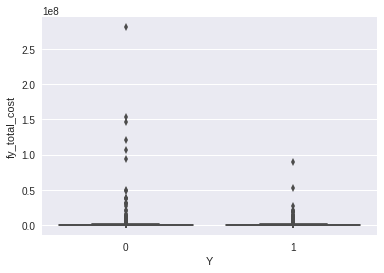

In [18]:
ax = sns.boxplot(x="Y", y="fy_total_cost", data=df_train)

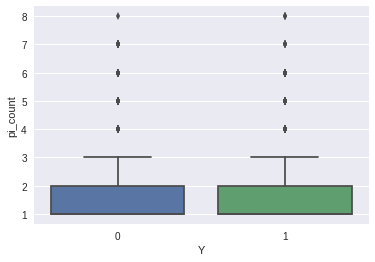

In [19]:
ax = sns.boxplot(x="Y", y="pi_count", data=df_train)

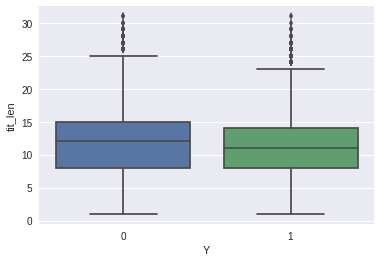

In [20]:
ax = sns.boxplot(x="Y", y="tit_len", data=df_train)

### Split into features and labels

In [21]:
filter_col = [col for col in df_train if col.startswith('organization')]
sel_features = ['fy_total_cost', 'fy_2008','fy_2009','fy_2010','fy_2011','fy_2012','fy_2013', 'fy_2014','fy_2015',
                'fy_2016', 'pi_count','tit_len'] + filter_col
sel_label = 'Y'

In [22]:
# use conventions typically used in python scikitlearn

X_train = df_train[sel_features].values
y_train = df_train[sel_label].values
X_test = df_test[sel_features].values
y_test = df_test[sel_label].values

# Model Selection

## Model Evaluation 
*[Go back to Table of Contents](#Table-of-Contents)*

In this phase, you take the predictors from your test set and apply your model to them, then assess the quality of the model by comparing the *predicted values* to the *actual values* for each record in your testing data set. 

- **Performance Estimation**: How well will our model do once it is deployed and applied to new data?

Now let's use the model we just fit to make predictions on our test dataset, and see what our accuracy score is:

Python's [`scikit-learn`](http://scikit-learn.org/stable/) is a commonly used, well documented Python library for machine learning. This library can help you split your data into training and test sets, fit models and use them to predict results on new data, and evaluate your results.

We will start with the simplest [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model and see how well that does.

You can use any number of metrics to judge your models (see [model evaluation](#model-evaluation)), but we'll use [`accuracy_score()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (ratio of correct predictions to total number of predictions) as our measure.

In [23]:
# Let's fit a model
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l1', C=1e5)
model.fit( X_train, y_train )
print(model)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


When we print the model results, we see different parameters we can adjust as we refine the model based on running it against test data (values such as `intercept_scaling`, `max_iters`, `penalty`, and `solver`).  

To adjust these parameters, one would alter the call that creates the `LogisticRegression()` model instance, passing it one or more of these parameters with a value other than the default.  So, to re-fit the model with `max_iter` of 1000, `intercept_scaling` of 2, and `solver` of "lbfgs" (pulled from thin air as an example), you'd create your model as follows:

    model = LogisticRegression( max_iter = 1000, intercept_scaling = 2, solver = "lbfgs" )

The basic way to choose values for, or "tune," these parameters is the same as the way you choose a model: fit the model to your training data with a variety of parameters, and see which perform the best on the test set. An obvious drawback is that you can also *overfit* to your test set; in this case, you can alter your method of cross-validation.



# Model Understanding

In [24]:
print "The coefficients for each of the features are " 
zip(sel_features, model.coef_[0])

The coefficients for each of the features are 


[('fy_total_cost', 1.1695477950013521e-07),
 ('fy_2008', 0.64449759565790476),
 ('fy_2009', 0.78608235973629847),
 ('fy_2010', 0.63645881629298473),
 ('fy_2011', 0.69488650959095277),
 ('fy_2012', 0.55321598770794178),
 ('fy_2013', 0.49110933466022749),
 ('fy_2014', 0.2142658779683633),
 ('fy_2015', -0.39769707152043826),
 ('fy_2016', -1.390093559809584),
 ('pi_count', -0.12522508526787055),
 ('tit_len', -0.015436318816009632),
 (u'organization_state_AK', -0.14779336381400515),
 (u'organization_state_AL', -0.071387959715085658),
 (u'organization_state_AR', -0.16289777958443355),
 (u'organization_state_AS', 0.0),
 (u'organization_state_AZ', 0.1764499435094613),
 (u'organization_state_CA', 0.054751370763851656),
 (u'organization_state_CO', 0.065681838455694905),
 (u'organization_state_CT', 0.23050163337304339),
 (u'organization_state_DC', -0.88786064826991506),
 (u'organization_state_DE', 0.24905769341940512),
 (u'organization_state_FL', 0.28133022986086842),
 (u'organization_state_FM', 

In [25]:
std_coef = np.std(X_test,0)*model.coef_
zip(sel_features, std_coef[0])

[('fy_total_cost', 0.12644826683990137),
 ('fy_2008', 0.19676593486997063),
 ('fy_2009', 0.27026431142115193),
 ('fy_2010', 0.20956683184982311),
 ('fy_2011', 0.21260535738072198),
 ('fy_2012', 0.17090283065126022),
 ('fy_2013', 0.14913804008172382),
 ('fy_2014', 0.064746780703532431),
 ('fy_2015', -0.12306010171600154),
 ('fy_2016', -0.4387415108367112),
 ('pi_count', -0.12933345223825618),
 ('tit_len', -0.071405712449938361),
 (u'organization_state_AK', -0.010657090441299841),
 (u'organization_state_AL', -0.0066498403869896649),
 (u'organization_state_AR', -0.0093049750470670205),
 (u'organization_state_AS', 0.0),
 (u'organization_state_AZ', 0.025981870732428063),
 (u'organization_state_CA', 0.018304824499391453),
 (u'organization_state_CO', 0.01075671448462733),
 (u'organization_state_CT', 0.027097698428934999),
 (u'organization_state_DC', -0.10923526654659275),
 (u'organization_state_DE', 0.020003474961837096),
 (u'organization_state_FL', 0.047910937727984895),
 (u'organization_sta

# Model Evaluation 

Machine learning models usually do not produce a prediction (0 or 1) directly. Rather, models produce a score between 0 and 1 (that can sometimes be interpreted as a probability), which lets you more finely rank all of the examples from *most likely* to *least likely* to have label 1 (positive). This score is then turned into a 0 or 1 based on a user-specified threshold. For example, you might label all examples that have a score greater than 0.5 (1/2) as positive (1), but there's no reason that has to be the cutoff. 

In [26]:
#  from our "predictors" using the model.
y_scores = model.predict_proba(X_test)[:,1]

In [27]:
y_scores

array([ 0.62169705,  0.63128395,  0.20859341, ...,  0.49121056,
        0.37742858,  0.59196592])

Let's take a look at the distribution of scores and see if it makes sense to us. 

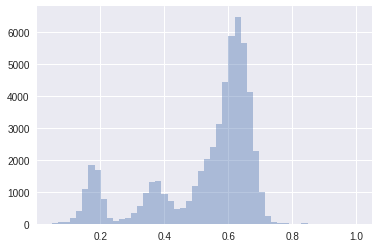

In [28]:
sns.distplot(y_scores, kde=False, rug=False)

In [29]:
df_test['y_score'] = y_scores

In [30]:
df_test[['y_score']].head()

,y_score
12422,0.621697
399578,0.631284
677648,0.208593
597664,0.370582
403262,0.654978


Tools like `sklearn` often have a default threshold of 0.5, but a good threshold is selected based on the data, model and the specific problem you are solving. As a trial run, let's set a threshold of 0.5. 

In [31]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.50) for score in y_scores] )
expected = y_test

## Confusion Matrix

Once we have tuned our scores to 0 or 1 for classification, we create a *confusion matrix*, which  has four cells: true negatives, true positives, false negatives, and false positives. Each data point belongs in one of these cells, because it has both a ground truth and a predicted label. If an example was predicted to be negative and is negative, it's a true negative. If an example was predicted to be positive and is positive, it's a true positive. If an example was predicted to be negative and is positive, it's a false negative. If an example was predicted to be positive and is negative, it's a false negative.

In [32]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print conf_matrix

[[10709 15381]
 [ 4661 24540]]


The count of true negatives is `conf_matrix[0,0]`, false negatives `conf_matrix[1,0]`, true positives `conf_matrix[1,1]`, and false_positives `conf_matrix[0,1]`.

Accuracy is the ratio of the correct predictions (both positive and negative) to all predictions. 
$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

In [33]:
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.63751786005


Two additional metrics that are often used are **precision** and **recall**. 

Precision measures the accuracy of the classifier when it predicts an example to be positive. It is the ratio of correctly predicted positive examples to examples predicted to be positive. 

$$ Precision = \frac{TP}{TP+FP}$$

Recall measures the accuracy of the classifier to find positive examples in the data. 

$$ Recall = \frac{TP}{TP+FN} $$

By selecting different thresholds we can vary and tune the precision and recall of a given classifier. A conservative classifier (threshold 0.99) will classify a case as 1 only when it is *very sure*, leading to high precision. On the other end of the spectrum, a low threshold (e.g. 0.01) will lead to higher recall. 

In [34]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.614714060269
Recall= 0.840382178693


If we care about our whole precision-recall space, we can optimize for a metric known as the **area under the curve (AUC-PR)**, which is the area under the precision-recall curve. The maximum AUC-PR is 1. 

In [35]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.655636


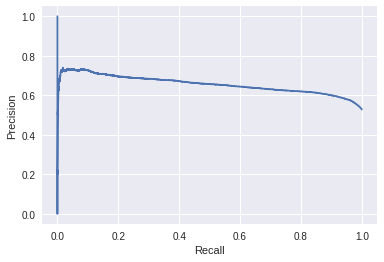

In [36]:
plot_precision_recall(expected, y_scores)

## Precision and Recall at k%

If we only care about a specific part of the precision-recall curve we can focus on more fine-grained metrics. For instance, say there is a year where an agency has funding constraints. They have less money to allocate in this given year. In that case, we would want to prioritize the 1% of applicants who are *most likely* to publish, and it doesn't matter too much how accurate we are on the ones who aren't very likely to publish. We can then focus on optimizing our **precision at 1%**.

In [37]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls 
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

In [38]:
def precision_at_k(y_true, y_scores,k):
    
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores ])
    return precision_score(y_true, y_pred)

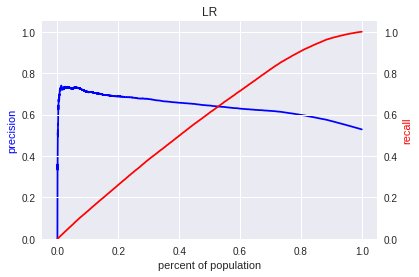

In [39]:
plot_precision_recall_n(expected,y_scores, 'LR')

In [40]:
p_at_1 = precision_at_k(expected,y_scores, 0.01)
print('Precision at 1%: {:.2f}'.format(p_at_1))

Precision at 1%: 0.72


# Assess Model Against Baselines

- Back to [Table of Contents](#Table-of-Contents)

It is important to check our model against a reasonable **baseline** to know how well our model is doing. Without any context, 78% accuracy can sound really great... but it's not so great when you remember that you could do almost that well by declaring everyone will not need benefits in the next year, which would be stupid (not to mention useless) model. 

A good place to start is checking against a *random* baseline, assigning every example a label (positive or negative) completely at random. 

In [41]:
random_score = [random.uniform(0,1) for i in enumerate(y_test)] 
random_predicted = np.array( [calc_threshold(score,0.5) for score in random_score] )
random_p_at_5 = precision_at_k(expected,random_predicted, 0.01)
print('Precision at 1% (random): {:.2f}'.format(random_p_at_5))

Precision at 1% (random): 0.53


## Decision Tree

In [42]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [43]:
#import graphviz 
#dot_data = tree.export_graphviz(clf_gini, out_file=None) 
#graph = graphviz.Source(dot_data) 

Unfortunately this package is not installed in our environment yet.

## You can produce Confusion Matrix and Precision and Recall to practice

# Survey of Algorithms

We have only scratched the surface of what we can do with our model. We've only tried one classifier (Logistic Regression), and there are plenty more classification algorithms in `sklearn`. Let's try them! 

In [44]:
clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
       'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SGD':SGDClassifier(loss='log'),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, random_state=17, n_estimators=10),
        'NB': GaussianNB()}

In [45]:
sel_clfs = ['RF', 'ET', 'LR', 'SGD', 'GB', 'NB']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


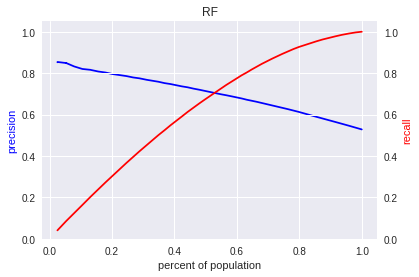

FEATURE IMPORTANCES
{u'organization_state_AZ': 0.0046856142797178438, u'organization_state_MP': 0.0, u'organization_state_CT': 0.0034446718561010697, u'organization_state_IL': 0.005881284430977172, u'organization_state_AR': 0.0016902999718065442, u'organization_state_AS': 0.0, u'organization_state_SC': 0.0028123016727285861, u'organization_state_AK': 0.0017704859562382117, u'organization_state_AL': 0.0028289568956789426, u'organization_state_HI': 0.0022611811966421667, u'organization_state_WV': 0.00099944609513509704, u'organization_state_GA': 0.0046692327699109134, u'organization_state_VT': 0.0011856635201960713, u'organization_state_CO': 0.0051648192695295204, u'organization_state_FM': 3.4962166967473453e-06, u'organization_state_FL': 0.0050776823374604719, u'organization_state_NV': 0.0012886429311771942, 'fy_2009': 0.009730700963497943, 'fy_2008': 0.0066757217669160367, u'organization_state_DC': 0.0049957729034133154, u'organization_state_PA': 0.0066401564765320061, u'organization_s

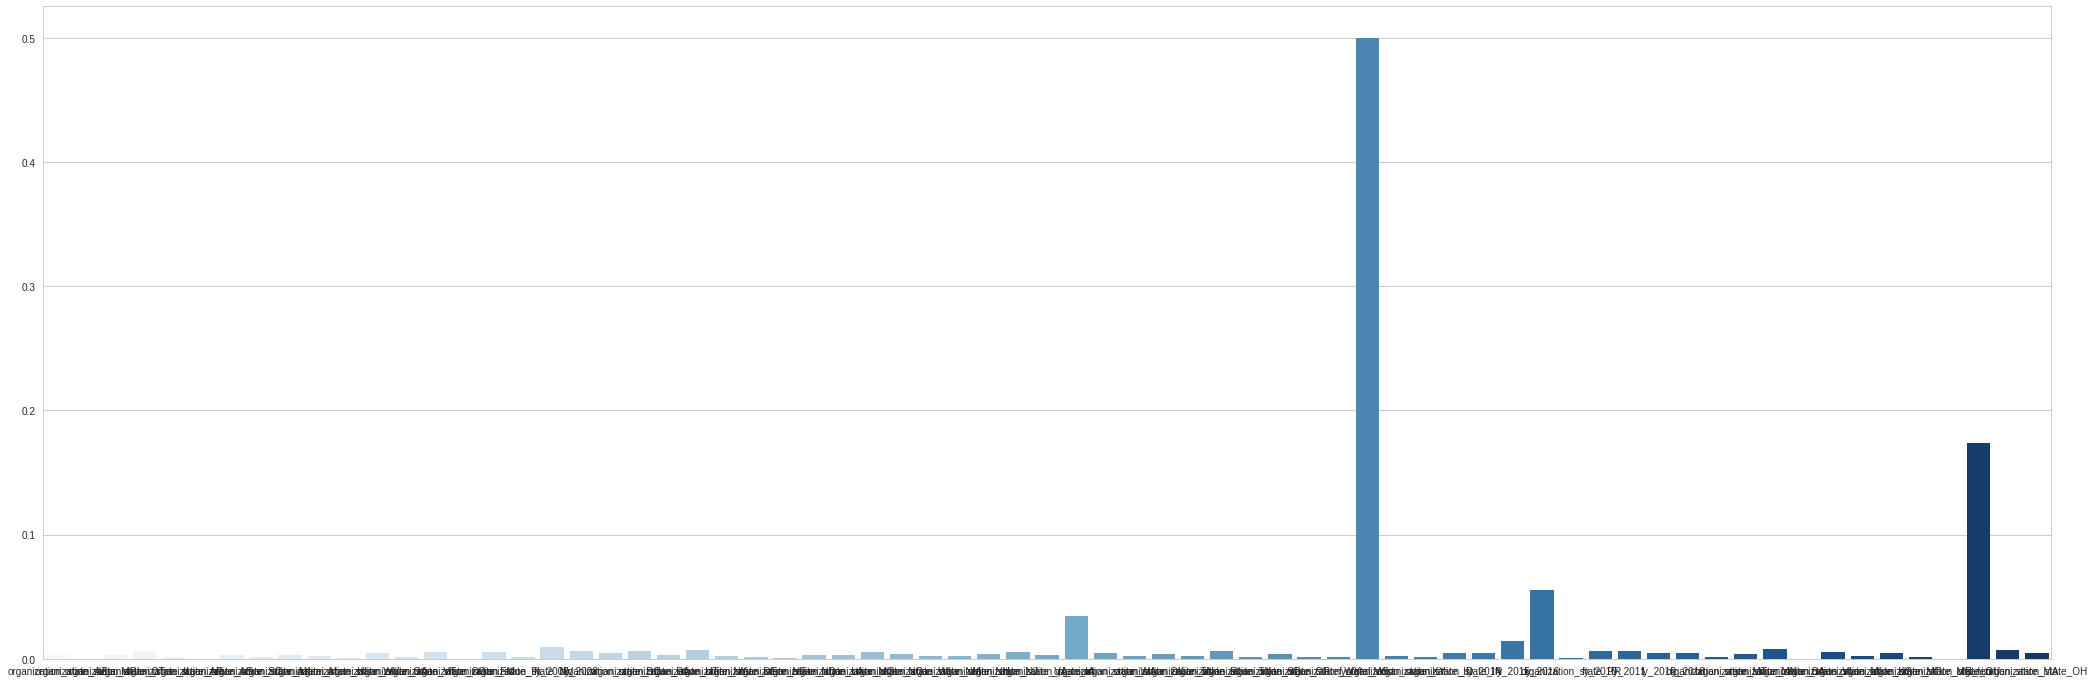

Precision at 1%: 0.85
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


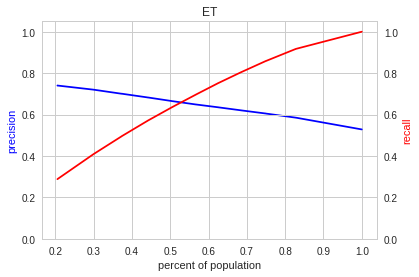

FEATURE IMPORTANCES
{u'organization_state_AZ': 0.0023095886558946515, u'organization_state_MP': 0.0, u'organization_state_CT': 0.0016823134206169908, u'organization_state_IL': 0.0017534513403664569, u'organization_state_AR': 0.00095431758094771842, u'organization_state_AS': 0.0, u'organization_state_SC': 0.0015323388758674212, u'organization_state_AK': 0.0010074754088704864, u'organization_state_AL': 0.0013504288291655913, u'organization_state_HI': 0.0012242186771757213, u'organization_state_WV': 0.00091852724203876754, u'organization_state_GA': 0.0022542765842241837, u'organization_state_VT': 0.00079284496937689355, u'organization_state_CO': 0.0026799214620013665, u'organization_state_FM': 2.5335316474917569e-05, u'organization_state_FL': 0.0019679910872727946, u'organization_state_NV': 0.00096500933605006003, 'fy_2009': 0.0070191504613590621, 'fy_2008': 0.0032380908607768564, u'organization_state_DC': 0.002594980244700363, u'organization_state_PA': 0.0027174864570201239, u'organizati

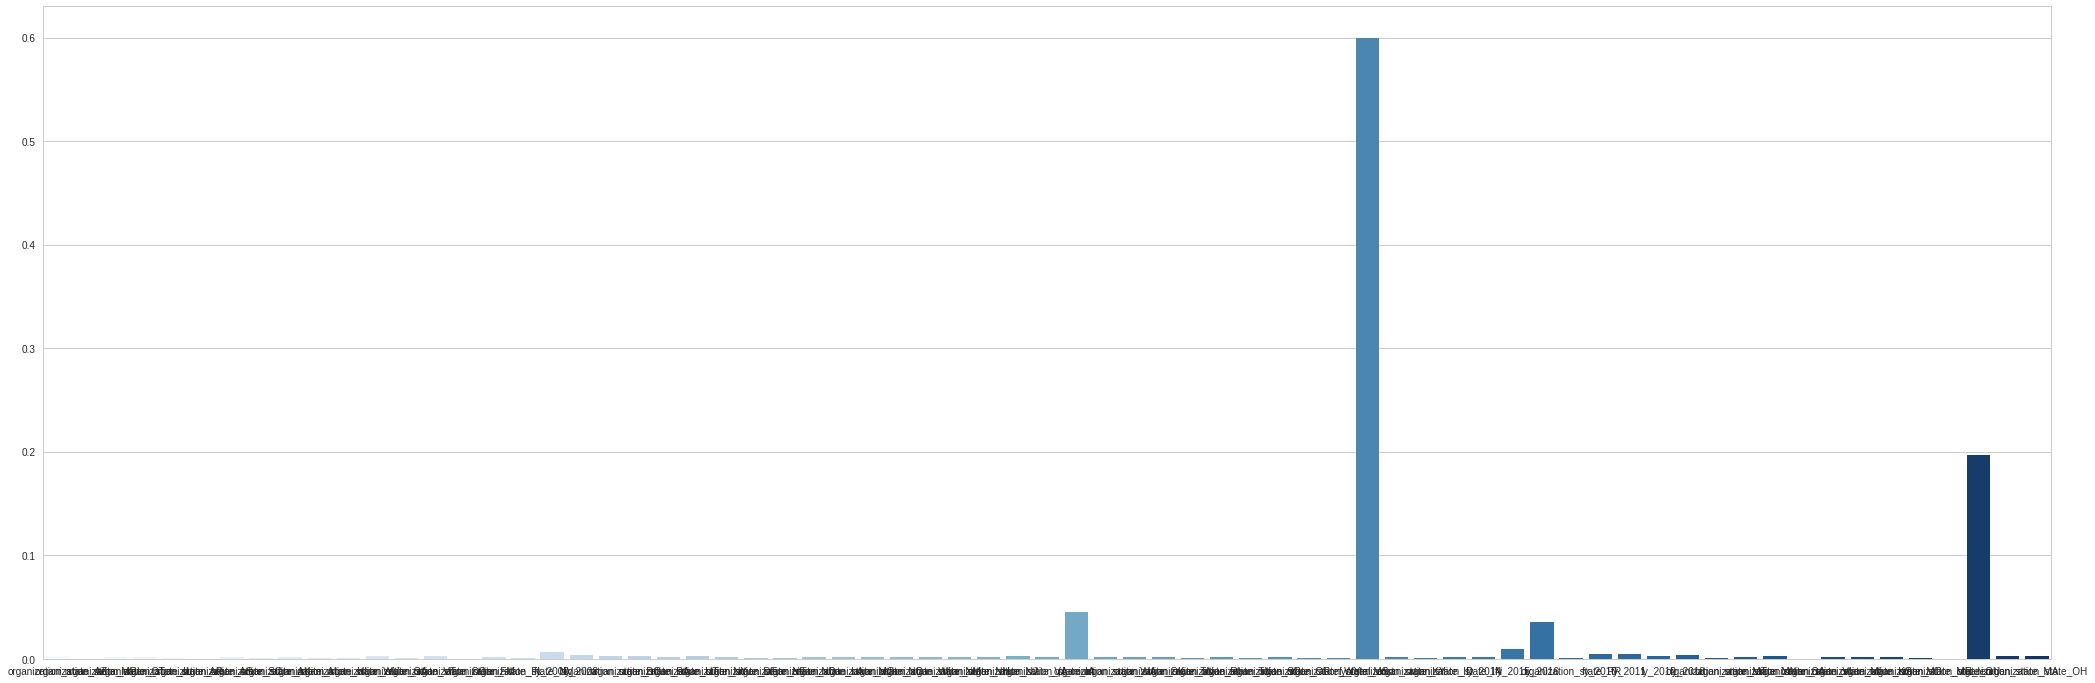

Precision at 1%: 0.74
LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


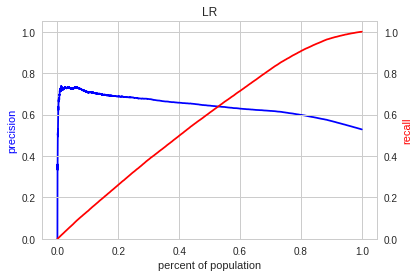

FEATURE IMPORTANCES
{u'organization_state_AZ': 0.1805490227031811, u'organization_state_MP': 0.0, u'organization_state_CT': 0.23326792558610357, u'organization_state_IL': 0.20441722433625095, u'organization_state_AR': -0.15904198565309824, u'organization_state_AS': 0.0, u'organization_state_SC': 0.15245695228799561, u'organization_state_AK': -0.14324698972773423, u'organization_state_AL': -0.066985199489023858, u'organization_state_HI': -0.024616087563972829, u'organization_state_WV': 0.1095901554566748, u'organization_state_GA': 0.20167263238674818, u'organization_state_VT': 0.066108899323187365, u'organization_state_CO': 0.070182447617856247, u'organization_state_FM': -11.809870443814026, u'organization_state_FL': 0.2851776833822251, u'organization_state_NV': 0.11580189196858061, 'fy_2009': 0.7978492270129367, 'fy_2008': 0.65574854108747793, u'organization_state_DC': -0.88450956792084845, u'organization_state_PA': 0.10457788342953621, u'organization_state_UT': 0.21791230358193786, u'

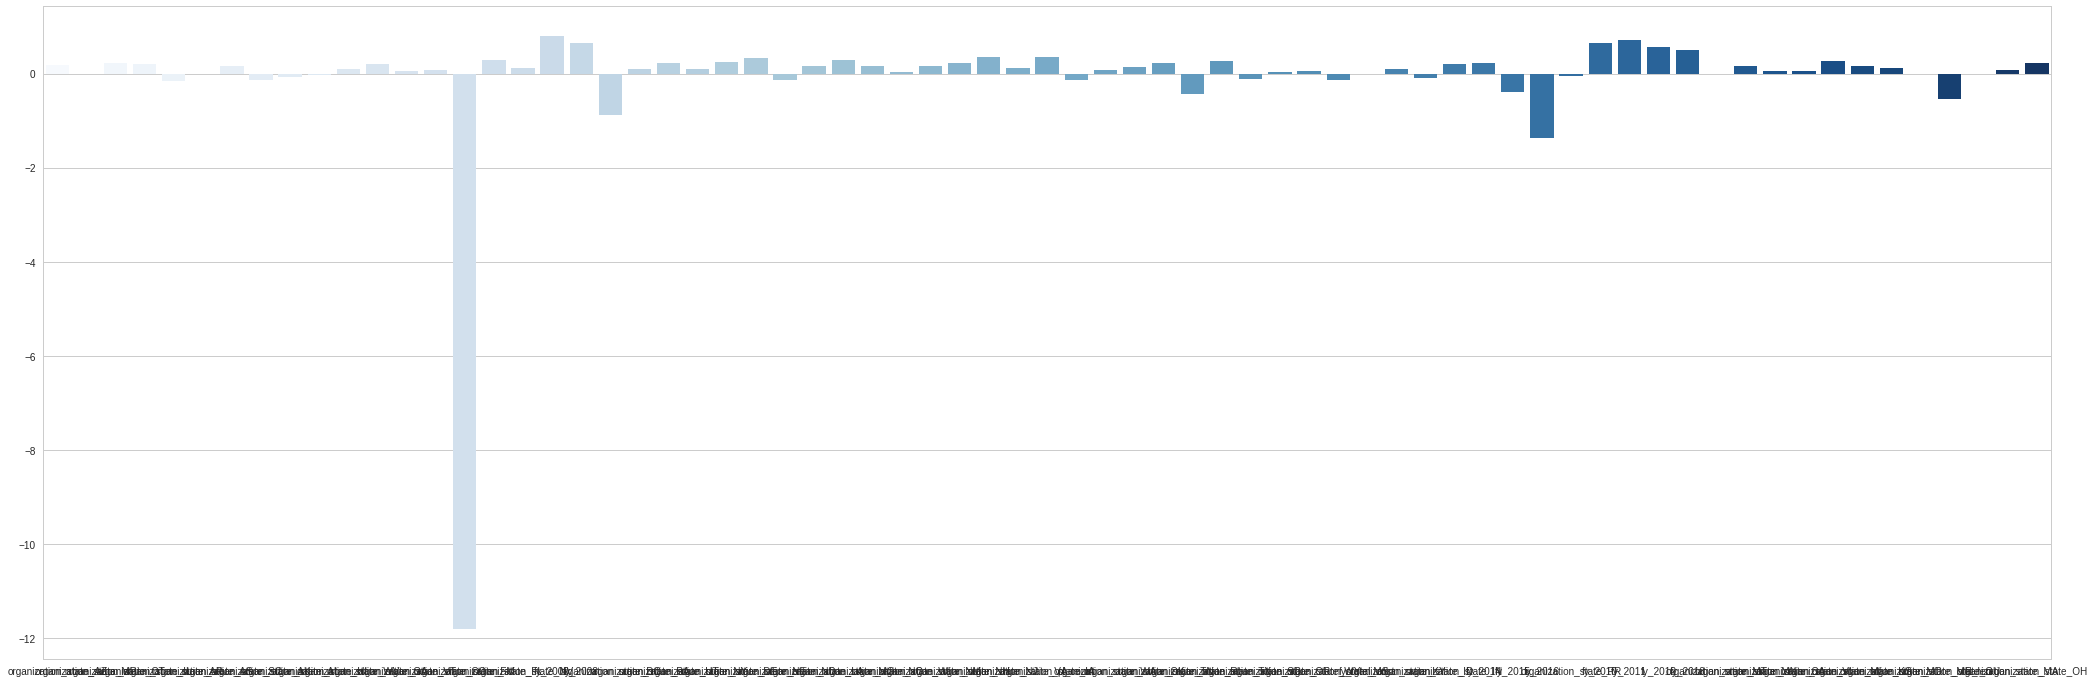

Precision at 1%: 0.72
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


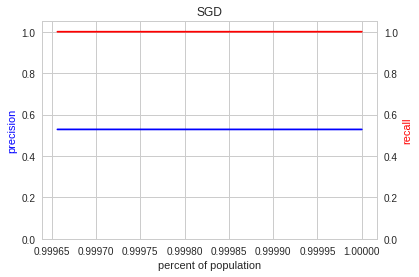

FEATURE IMPORTANCES
{u'organization_state_AZ': -9.3348807369865821, u'organization_state_MP': 0.0, u'organization_state_CT': -1.0812603170255106, u'organization_state_IL': -6.2713098387476345, u'organization_state_AR': -3.243780951076408, u'organization_state_AS': 0.0, u'organization_state_SC': -3.8925371412917258, u'organization_state_AK': -5.1900495217223028, u'organization_state_AL': -8.2896624305286437, u'organization_state_HI': -4.8296294160471209, u'organization_state_WV': -0.93709227475540491, u'organization_state_GA': -5.1179655005872009, u'organization_state_VT': -0.86500825362038813, u'organization_state_CO': -13.73200602622355, u'organization_state_FM': -0.14416804227006369, u'organization_state_FL': -2.7031507925636693, u'organization_state_NV': -0.79292423248534749, 'fy_2009': 108.12603170254413, 'fy_2008': 52.080705270058836, u'organization_state_DC': -40.042673740509095, u'organization_state_PA': -23.787726974560556, u'organization_state_UT': -2.1625206340509693, u'organ

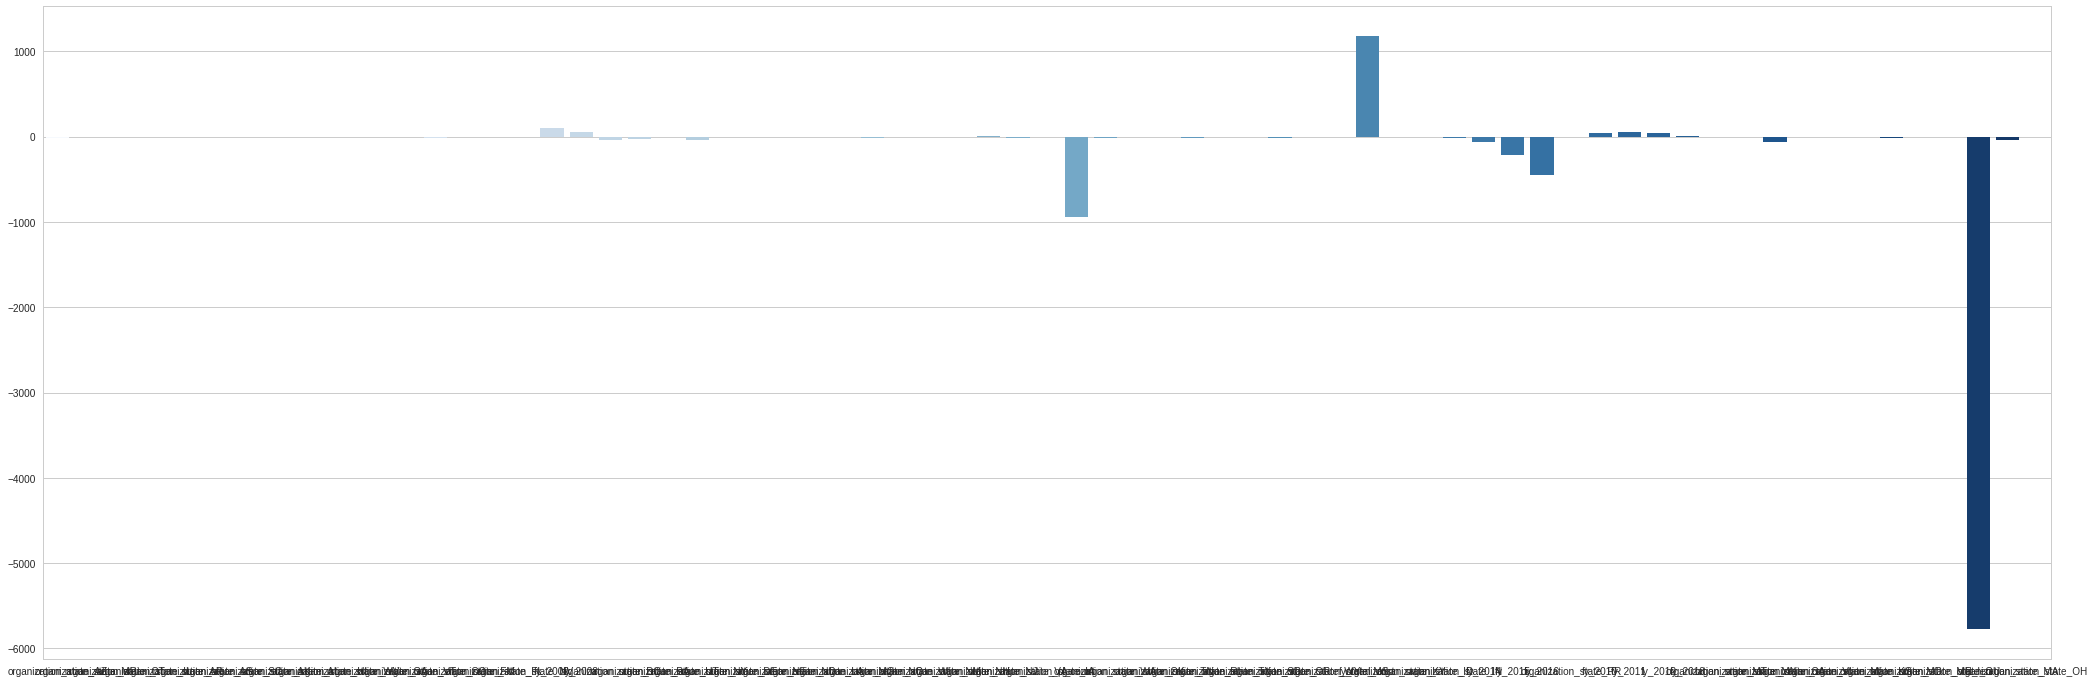

Precision at 1%: 0.53
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=17,
              subsample=0.5, verbose=0, warm_start=False)


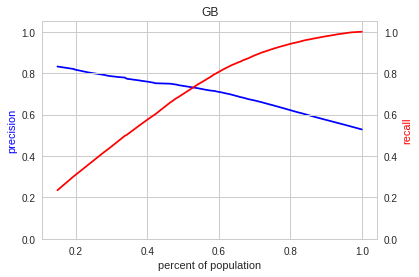

FEATURE IMPORTANCES
{u'organization_state_AZ': 6.0480380930400305e-05, u'organization_state_MP': 0.0, u'organization_state_CT': 0.00012489680921754211, u'organization_state_IL': 0.00032488351724226593, u'organization_state_AR': 0.00024349634239809989, u'organization_state_AS': 0.0, u'organization_state_SC': 0.00015553184755569331, u'organization_state_AK': 5.8130139530487195e-05, u'organization_state_AL': 4.4689032114722731e-05, u'organization_state_HI': 0.00015552468801282831, u'organization_state_WV': 0.0, u'organization_state_GA': 0.00020080170627132893, u'organization_state_VT': 0.00031722342711138147, u'organization_state_CO': 0.00037421561036907349, u'organization_state_FM': 0.0, u'organization_state_FL': 0.00048005340277603446, u'organization_state_NV': 0.00030290577516149176, 'fy_2009': 0.00011037326071286649, 'fy_2008': 0.00024275674180846888, u'organization_state_DC': 0.0033020214455482212, u'organization_state_PA': 0.00013936188274652189, u'organization_state_UT': 2.60337668

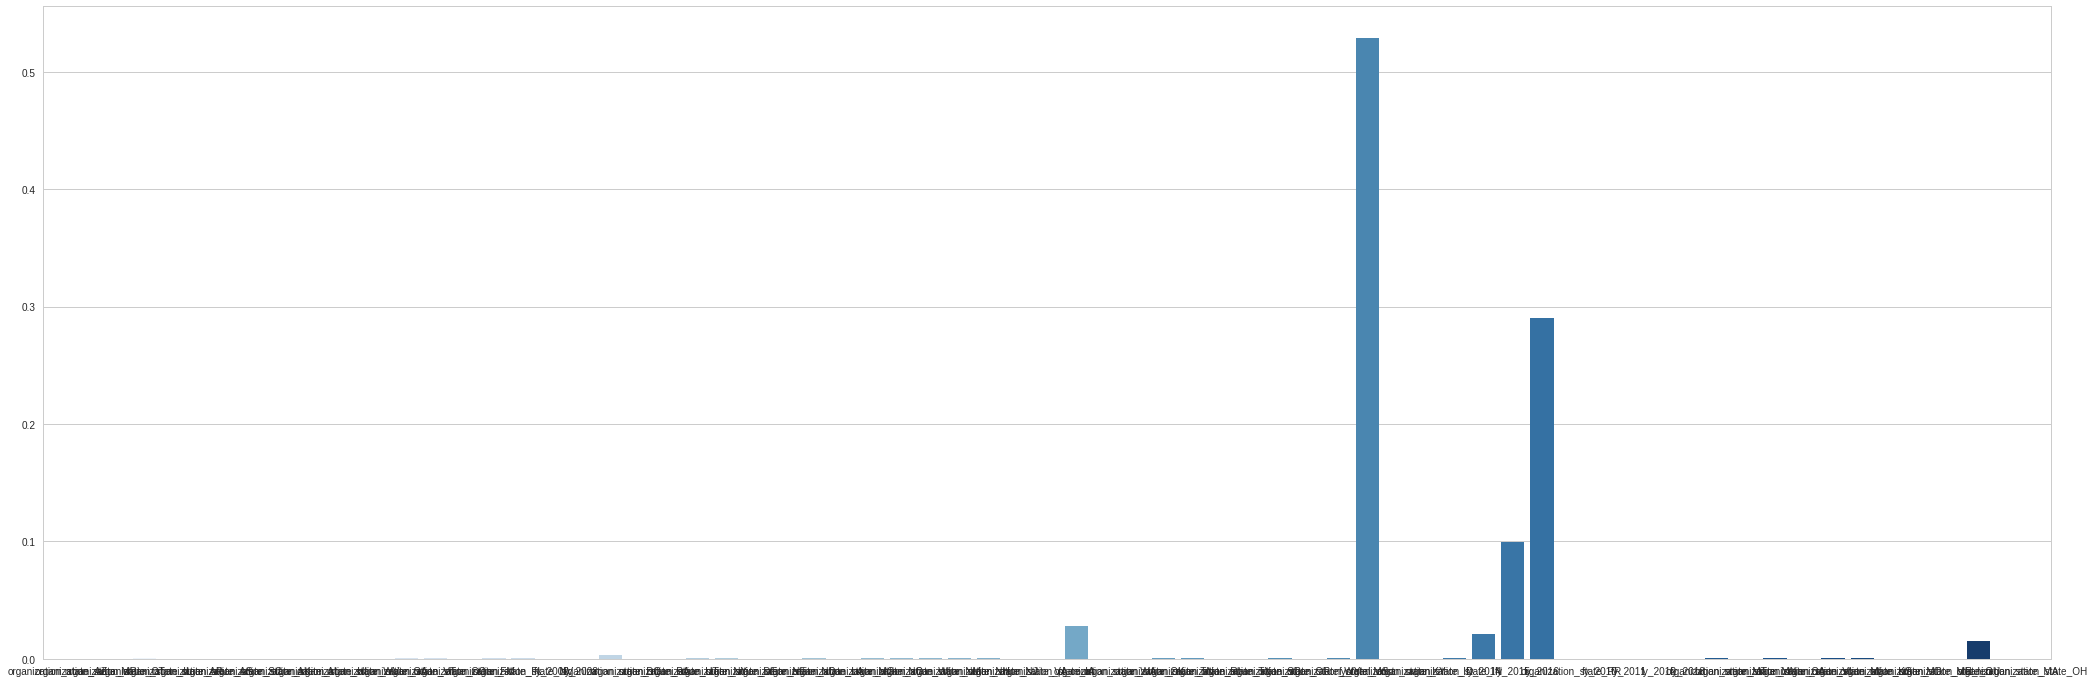

Precision at 1%: 0.83
GaussianNB(priors=None)


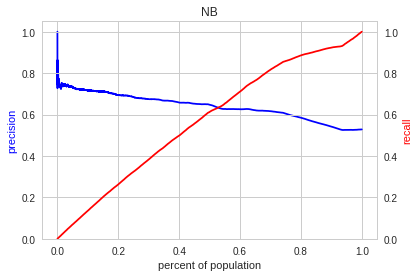

FEATURE IMPORTANCES
{u'organization_state_AZ': 6.0480380930400305e-05, u'organization_state_MP': 0.0, u'organization_state_CT': 0.00012489680921754211, u'organization_state_IL': 0.00032488351724226593, u'organization_state_AR': 0.00024349634239809989, u'organization_state_AS': 0.0, u'organization_state_SC': 0.00015553184755569331, u'organization_state_AK': 5.8130139530487195e-05, u'organization_state_AL': 4.4689032114722731e-05, u'organization_state_HI': 0.00015552468801282831, u'organization_state_WV': 0.0, u'organization_state_GA': 0.00020080170627132893, u'organization_state_VT': 0.00031722342711138147, u'organization_state_CO': 0.00037421561036907349, u'organization_state_FM': 0.0, u'organization_state_FL': 0.00048005340277603446, u'organization_state_NV': 0.00030290577516149176, 'fy_2009': 0.00011037326071286649, 'fy_2008': 0.00024275674180846888, u'organization_state_DC': 0.0033020214455482212, u'organization_state_PA': 0.00013936188274652189, u'organization_state_UT': 2.60337668

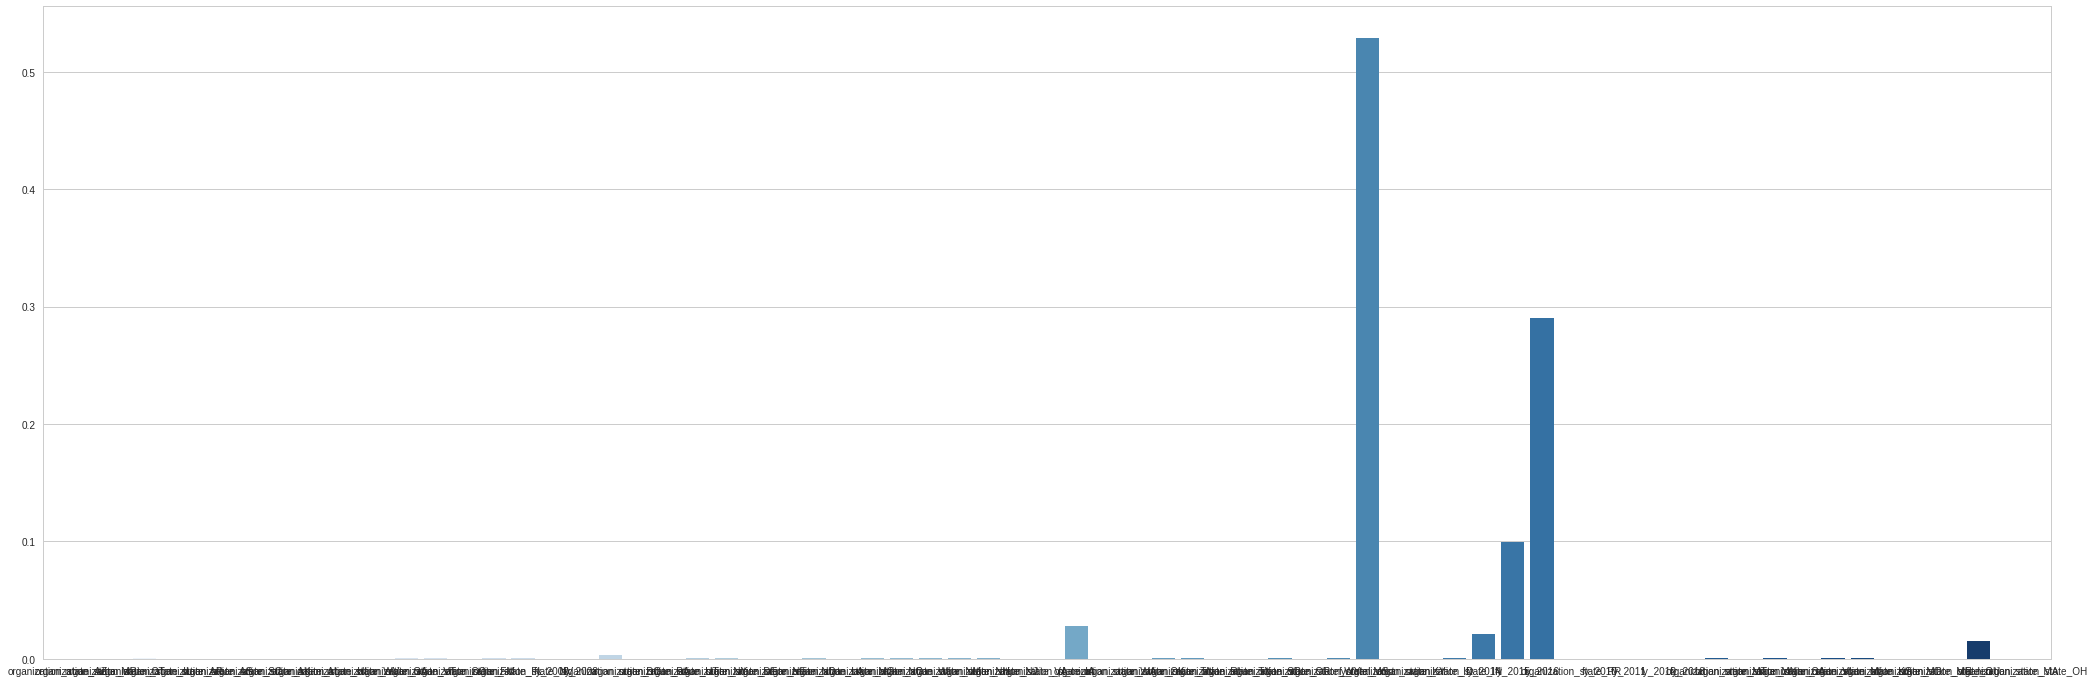

Precision at 1%: 0.74


In [46]:
max_p_at_k = 0
df_results = pd.DataFrame()
for clfNM in sel_clfs:
    clf = clfs[clfNM]
    clf.fit( X_train, y_train )
    print clf
    y_score = clf.predict_proba(X_test)[:,1]
    predicted = np.array(y_score)
    expected = np.array(y_test)
    plot_precision_recall_n(expected,predicted, clfNM)
    p_at_1 = precision_at_k(expected,y_score, 0.01)
    p_at_5 = precision_at_k(expected,y_score,0.05)
    p_at_10 = precision_at_k(expected,y_score,0.10)
    fpr, tpr, thresholds = roc_curve(expected,y_score)
    auc_val = auc(fpr,tpr)
    df_results = df_results.append([{
        'clfNM':clfNM,
        'p_at_1':p_at_1,
        'p_at_5':p_at_5,
        'p_at_10':p_at_10,
        'auc':auc_val,
        'clf': clf
    }])
    
    #feature importances
    if hasattr(clf, 'coef_'):
        feature_import = dict(
            zip(sel_features,clf.coef_.ravel()))
    elif hasattr(clf, 'feature_importances_'):
        feature_import = dict(
            zip(sel_features, clf.feature_importances_))
    print("FEATURE IMPORTANCES")
    print(feature_import)
    
    plt.clf()
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(36,12))
    sns.barplot(x=feature_import.keys(), y = feature_import.values(), palette="Blues")
    plt.show()
    
    if max_p_at_k < p_at_1:
        max_p_at_k = p_at_1
    print('Precision at 1%: {:.2f}'.format(p_at_1))
df_results.to_csv('modelrun.csv')

In [47]:
max_p_at_k

0.85243553008595985

## Machine Learning Pipeline
*[Go back to Table of Contents](#Table-of-Contents)*

When working on machine learning projects, it is a good idea to structure your code as a modular **pipeline**, which contains all of the steps of your analysis, from the original data source to the results that you report, along with documentation. This has many advantages:
- **Reproducibility**. It's important that your work be reproducible. This means that someone else should be able
to see what you did, follow the exact same process, and come up with the exact same results. It also means that
someone else can follow the steps you took and see what decisions you made, whether that person is a collaborator, 
a reviewer for a journal, or the agency you are working with. 
- **Ease of model evaluation and comparison**.
- **Ability to make changes.** If you receive new data and want to go through the process again, or if there are 
updates to the data you used, you can easily substitute new data and reproduce the process without starting from scratch.

## Resources
*[Go back to Table of Contents](#Table-of-Contents)*

- Hastie et al.'s [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) is a classic and is available online for free.
- James et al.'s [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/), also available online, includes less mathematics and is more approachable.
- Wu et al.'s [Top 10 Algorithms in Data Mining](http://www.cs.uvm.edu/~icdm/algorithms/10Algorithms-08.pdf).